In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinConfig, SwinModel
import albumentations as A
# --- Cài đặt tham số cố định ---
IMG_SIZE = 320
BATCH_SIZE = 8 # Điều chỉnh nếu bạn gặp lỗi hết bộ nhớ GPU
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

try:
    train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
    train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
    val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
    val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])
    print(f"Found {len(train_img_paths)} training images and {len(val_img_paths)} validation images.")
except FileNotFoundError:
    print("One of the directories was not found. Please check the paths.")
    exit()

class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, img_size, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.img_size = img_size
        self.augment = augment

        if len(self.image_filenames) != len(self.mask_filenames):
            raise ValueError("Number of image files and mask files do not match.") # Số lượng tệp ảnh và tệp mask không khớp.

    def __len__(self):
        return len(self.image_filenames)

    def resize_image_and_mask(self, img, mask, target_size=IMG_SIZE):
        return img, mask

    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        if img is None:
            raise ValueError(f"Could not read image file: {self.image_filenames[idx]}")

        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not read mask file: {self.mask_filenames[idx]}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize về IMG_SIZE nếu cần
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        # Augmentation với Albumentations
        if self.augment:
            aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5)
            ])
            augmented = aug(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)
        elif mask.ndim == 3 and mask.shape[0] != 1:
            if mask.shape[0] == 3:
                mask = mask[0:1, :, :]
            else:
                raise ValueError(f"Mask has unexpected shape {mask.shape} at index {idx} after transform.")

        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        mask_tensor = torch.from_numpy(mask)

        return img_tensor, mask_tensor



c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda
Found 1500 training images and 400 validation images.


In [ ]:

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, out_channels, pool_scales):
        super(PyramidPoolingModule, self).__init__()
        self.pool_layers = nn.ModuleList()
        for scale in pool_scales:
            self.pool_layers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        
        self.total_channels = in_channels + len(pool_scales) * out_channels
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(self.total_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        input_size = x.shape[2:]
        ppm_outs = [x]
        for pool_layer in self.pool_layers:
            pooled = pool_layer(x)
            upsampled = F.interpolate(pooled, size=input_size, mode='bilinear', align_corners=True)
            ppm_outs.append(upsampled)
        
        fusion = torch.cat(ppm_outs, dim=1)
        output = self.fusion_conv(fusion)
        return output

class SwinUPerNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, fpn_out_channels=256):
        super().__init__()
        self.IMG_SIZE = IMG_SIZE
        self.fpn_out_channels = fpn_out_channels

        config = SwinConfig(image_size=self.IMG_SIZE, num_channels=input_channels,
                            patch_size=4, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32],
                            window_size=7, mlp_ratio=4., qkv_bias=True, hidden_dropout_prob=0.0,
                            attention_probs_dropout_prob=0.0, drop_path_rate=0.1,
                            out_features=["stage1", "stage2", "stage3", "stage4"])
        self.swin = SwinModel(config)
        
        encoder_channels = [config.embed_dim * (2**i) for i in range(4)] # [128, 256, 512, 1024]

        self.ppm = PyramidPoolingModule(
            in_channels=encoder_channels[3],
            out_channels=self.fpn_out_channels,
            pool_scales=(1, 2, 3, 6) 
        )

        self.fpn_in = nn.ModuleList()
        self.fpn_out = nn.ModuleList()

        for in_channels in encoder_channels[:-1]: 
            self.fpn_in.append(nn.Sequential(
                nn.Conv2d(in_channels, self.fpn_out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(self.fpn_out_channels),
                nn.ReLU(inplace=True)
            ))
        
        for _ in range(len(encoder_channels) - 1):
             self.fpn_out.append(nn.Sequential(
                nn.Conv2d(self.fpn_out_channels, self.fpn_out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(self.fpn_out_channels),
                nn.ReLU(inplace=True)
            ))

        self.fusion_conv = nn.Sequential(
            nn.Conv2d(len(encoder_channels) * self.fpn_out_channels, self.fpn_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(self.fpn_out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.final_conv = nn.Conv2d(self.fpn_out_channels, num_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]

        outputs = self.swin(pixel_values=x, output_hidden_states=True)
        all_features = outputs.reshaped_hidden_states
        c2, c3, c4, c5 = all_features[:4]

        p5 = self.ppm(c5)

        f4 = self.fpn_in[2](c4)
        f3 = self.fpn_in[1](c3)
        f2 = self.fpn_in[0](c2)

        p4 = self.fpn_out[0](f4 + F.interpolate(p5, size=f4.shape[2:], mode='bilinear', align_corners=True))

        p3 = self.fpn_out[1](f3 + F.interpolate(p4, size=f3.shape[2:], mode='bilinear', align_corners=True))
        
        p2 = self.fpn_out[2](f2 + F.interpolate(p3, size=f2.shape[2:], mode='bilinear', align_corners=True))
        
        p5_up = F.interpolate(p5, size=p2.shape[2:], mode='bilinear', align_corners=True)
        p4_up = F.interpolate(p4, size=p2.shape[2:], mode='bilinear', align_corners=True)
        p3_up = F.interpolate(p3, size=p2.shape[2:], mode='bilinear', align_corners=True)
        
        fpn_fusion = torch.cat([p5_up, p4_up, p3_up, p2], dim=1)
        
        fused_output = self.fusion_conv(fpn_fusion)
        
        output = F.interpolate(fused_output, size=input_size, mode='bilinear', align_corners=True)
        
        output = self.final_conv(output)

        return output

In [3]:
class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        union = (inputs + targets).sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou

def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    dice = (2. * intersection + smooth) / ((predicted_masks.sum() + true_masks.sum()) + smooth)
    return iou.item(), dice.item()


In [4]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_loss_so_far=float('inf'), history=None):
    best_val_loss = best_val_loss_so_far 
    patience_counter = 0
    model_checkpoint_path = callbacks_config.get('checkpoint_path', 'model_best.pth')
    
    if history is None:
        history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': [], 'train_f1': [], 'val_f1': [], 'lr': []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, running_iou, running_f1 = 0.0, 0.0, 0.0
        print(f"Epoch {epoch+1}/{num_epochs} starting...")
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            batch_iou, batch_f1 = calculate_metrics(predicted_masks, masks)
            running_iou += batch_iou * images.size(0)
            running_f1 += batch_f1 * images.size(0)

            if (batch_idx + 1) % 20 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)
        epoch_f1 = running_f1 / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss); history['train_iou'].append(epoch_iou); history['train_f1'].append(epoch_f1)
        print(f"Epoch {epoch+1} Finished - Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train F1: {epoch_f1:.4f}")

        model.eval()
        val_loss, val_iou, val_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                batch_iou, batch_f1 = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou * images.size(0)
                val_f1 += batch_f1 * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        history['val_loss'].append(val_loss); history['val_iou'].append(val_iou); history['val_f1'].append(val_f1)
        print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation F1: {val_f1:.4f}")
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        print(f"Current Learning Rate: {current_lr:.8f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"Best validation loss updated: {best_val_loss:.4f}. Saving model...")
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), 'best_val_loss': best_val_loss,
                        'scheduler_state_dict': scheduler.state_dict(), 'history': history},
                       model_checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
    return history


In [5]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    plt.plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch'), plt.ylabel('IoU'), plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1'], 'o-', label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], 'o-', label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epoch'), plt.ylabel('F1-Score'), plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['lr'], 'o-', label='Learning Rate', color='purple')
    plt.title('Learning Rate per Epoch')
    plt.xlabel('Epoch'), plt.ylabel('Learning Rate'), plt.legend()

    plt.tight_layout()
    plt.show()

Model: SwinUPerNet initialized with 96,874,937 trainable parameters.
No checkpoint found. Starting training from scratch.

--- Starting Swin-UPerNet Training ---
Epoch 1/200 starting...
  Batch 20/188, Loss: 0.9261
  Batch 40/188, Loss: 0.9534
  Batch 60/188, Loss: 0.9241
  Batch 80/188, Loss: 0.9705
  Batch 100/188, Loss: 0.9157
  Batch 120/188, Loss: 0.7686
  Batch 140/188, Loss: 0.8403
  Batch 160/188, Loss: 0.7521
  Batch 180/188, Loss: 0.7871
Epoch 1 Finished - Train Loss: 0.8595, Train IoU: 0.2455, Train F1: 0.3758
Validation Loss: 0.8408, Validation IoU: 0.2855, Validation F1: 0.4169
Current Learning Rate: 0.00010000
Best validation loss updated: 0.8408. Saving model...
Epoch 2/200 starting...
  Batch 20/188, Loss: 0.7595
  Batch 40/188, Loss: 0.7539
  Batch 60/188, Loss: 0.5890
  Batch 80/188, Loss: 0.5857
  Batch 100/188, Loss: 0.5589
  Batch 120/188, Loss: 0.6518
  Batch 140/188, Loss: 0.5389
  Batch 160/188, Loss: 0.6995
  Batch 180/188, Loss: 0.5993
Epoch 2 Finished - Train

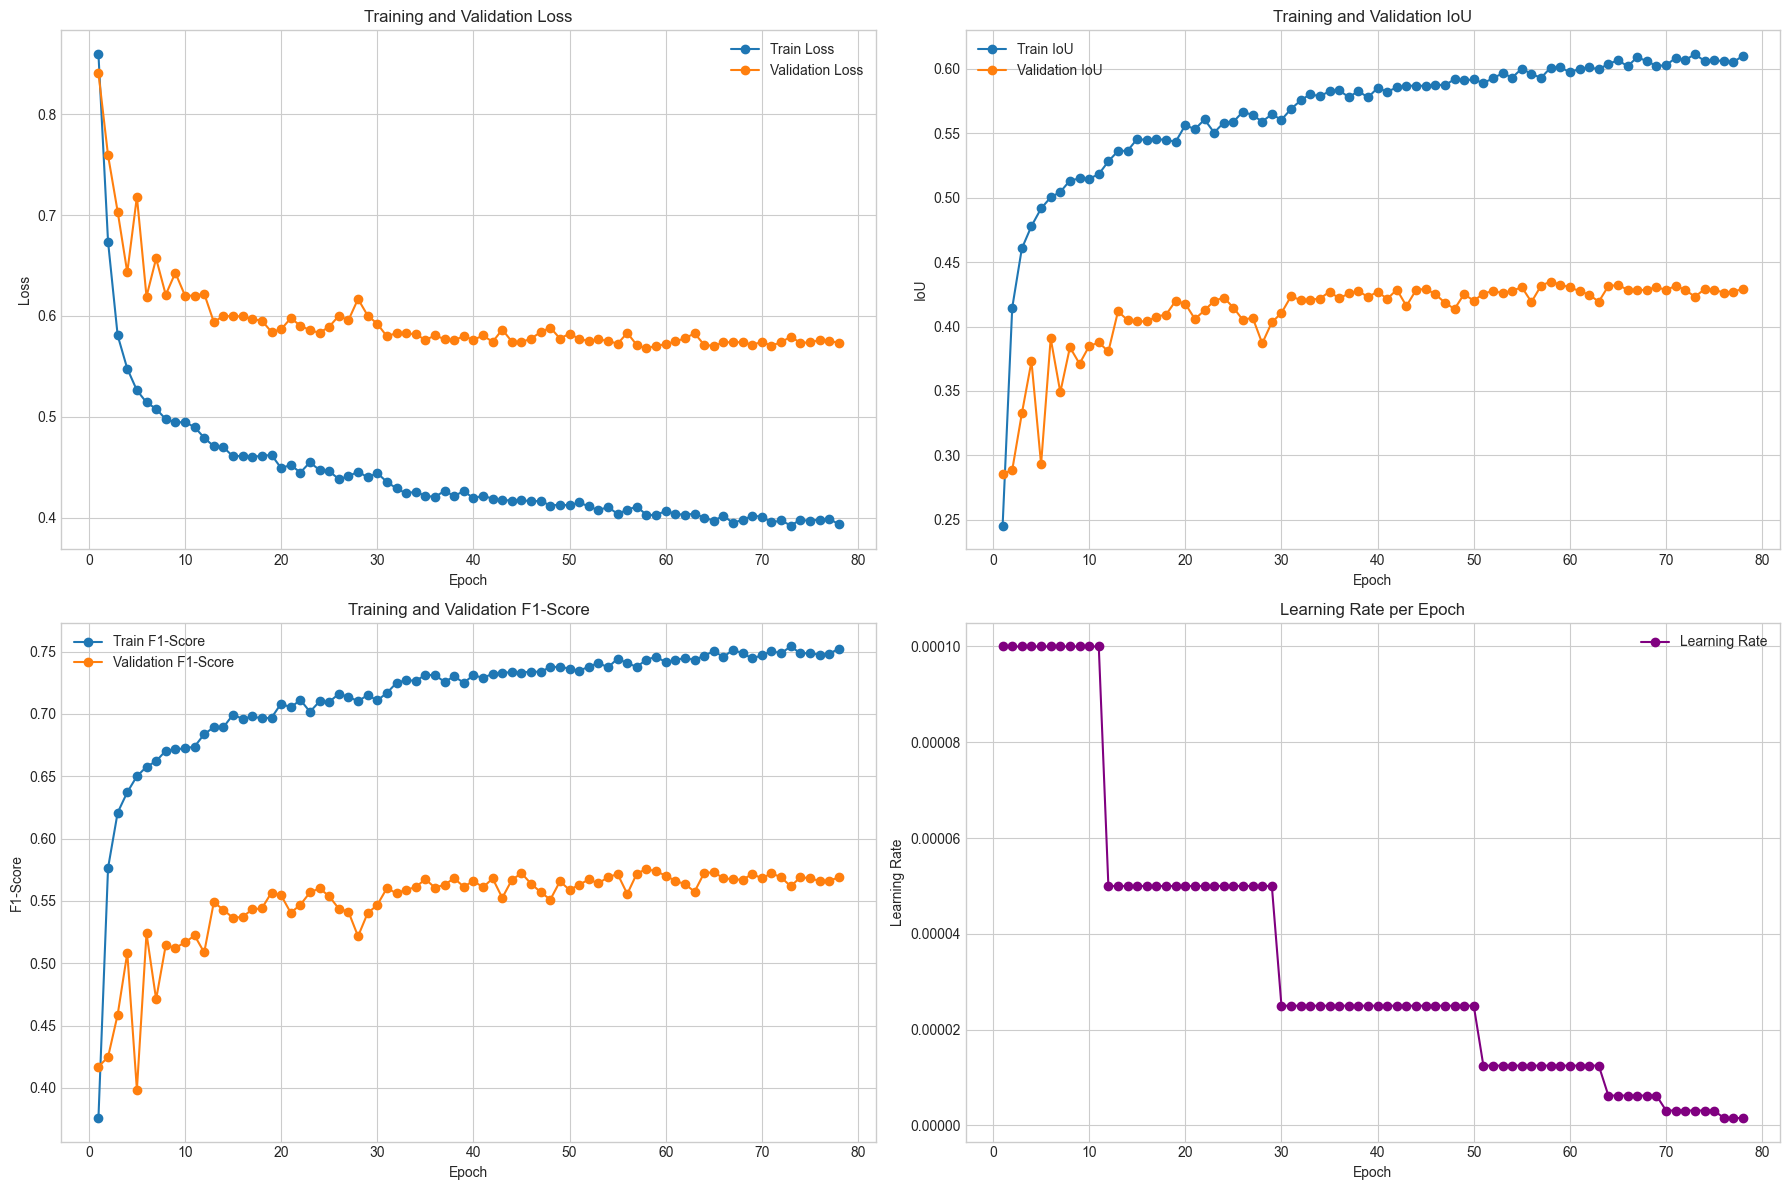

In [6]:
if __name__ == '__main__':
    # --- Chuẩn bị dữ liệu ---
    train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, img_size=IMG_SIZE, augment=True)
    val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, img_size=IMG_SIZE, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    # --- Khởi tạo mô hình, optimizer, criterion ---
    model = SwinUPerNet(input_channels=3, num_classes=1).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)
    criterion = IoULoss()

    print(f"Model: SwinUPerNet initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

    callbacks_config = {
        'patience': 20,
        'checkpoint_path': 'swin_upernet_best.pth' # Tên checkpoint mới cho model UPerNet
    }

    # --- Logic để tiếp tục huấn luyện từ checkpoint ---
    start_epoch = 0
    best_val_loss_so_far = float('inf')
    checkpoint_path = callbacks_config['checkpoint_path']
    history = None

    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at {checkpoint_path}. Loading to resume training...")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("Scheduler state loaded.")
        
        start_epoch = checkpoint['epoch'] + 1 
        best_val_loss_so_far = checkpoint['best_val_loss']
        
        if 'history' in checkpoint:
            history = checkpoint['history']
            print("Training history loaded from checkpoint.")
        
        print(f"Resuming training from Epoch {start_epoch}. Previous best val loss: {best_val_loss_so_far:.4f}")
    else:
        print("No checkpoint found. Starting training from scratch.")

    print("\n--- Starting Swin-UPerNet Training ---")
    training_history = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler,
                                   num_epochs=200, callbacks_config=callbacks_config,
                                   start_epoch=start_epoch, best_val_loss_so_far=best_val_loss_so_far,
                                   history=history)

    print("\n--- Training complete. ---")

    if training_history and len(training_history['train_loss']) > 0:
        print("Plotting training history...")
        plot_training_history(training_history)
    else:
        print("No training history available to plot.")